In [1]:
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from random import choice
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [2]:
State = namedtuple('State', ['x', 'o'])

In [3]:
MAGIC = [2, 7, 6, 9, 5, 1, 4, 3, 8]

In [4]:
def print_board(pos):
    """Nicely prints the board"""
    for r in range(3):
        for c in range(3):
            i = r * 3 + c
            if MAGIC[i] in pos.x:
                print('X', end='')
            elif MAGIC[i] in pos.o:
                print('O', end='')
            else:
                print('.', end='')
        print()
    print()

In [99]:
def win(elements):
    """Checks is elements is winning"""
    #print("state evaluation. Elements: ",elements)
    return any(sum(c) == 15 for c in combinations(elements, 3))

'''A reward is calculated for each state of each game.
The reward is calculated as the evaluation of the final state of the game.
In this case, the evaluation is done by the state_value() function, which returns a value between -1 and 1.'''

def state_value(pos: State):
    """Evaluate state: +1 first player wins"""

    if win(pos.x):
        #print_board(State)
        return -10
    elif win(pos.o):
        #print_board(State)
        return 100
    else:
        return -5



In [6]:
#useful to convert from the State conventiion to a 1-D grid (useful for debugging or gray_code)
def state_to_matrix(state):
  matrix = np.empty((9,1),dtype=str)
  for i,_ in enumerate(matrix) : matrix[i] = "."

  for i in state.x:
    matrix[i-1] = "X"

  for i in state.o:
    matrix[i-1,0] = "O"

  return matrix


def gray_code(state):
  """
  Converts the tic tac toe matrix to a trinary number using Gray's encoding algorithm.
  It's usefull to convert a state on the game grid into a index number for the Q-table

  Args:
    state: actua tic tac toe grid situation.

  Returns:
    Converted trinary number
  """
  matrix = state_to_matrix(state)
  # print(matrix)
  numbers = []
  for symbol in matrix:
    if symbol == "X":
      numbers.append(1)
    elif symbol == "O":
      numbers.append(0)
    else:
      numbers.append(2)

  binary_number = "".join(str(n) for n in numbers)
  return int(binary_number, 3)

# matrix = ["O", "O", "O", "O", "O", "O", "O", "X", "."]
# state = State(set(), set())
# state.x.add(1)
# state.x.add(5)
# state.o.add(4)

# index = gray_code(state)

# print(index)

In [7]:


#define the shape of the environment (i.e., its states)
num_states = pow(3,9)  #each state is a configuration of the table -> on each position can be drawn a X,O or . so we have 3^9 possible states
num_actions = 9 # O on one of the 9 positions

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a)
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions).
#The value of each (state, action) pair is initialized to 0.
q_table = np.zeros((num_states, num_actions))

#put all of them equal to -1 to find the shortest solution ???
#for id,_ in enumerate(q_table): q_table[id] = -1




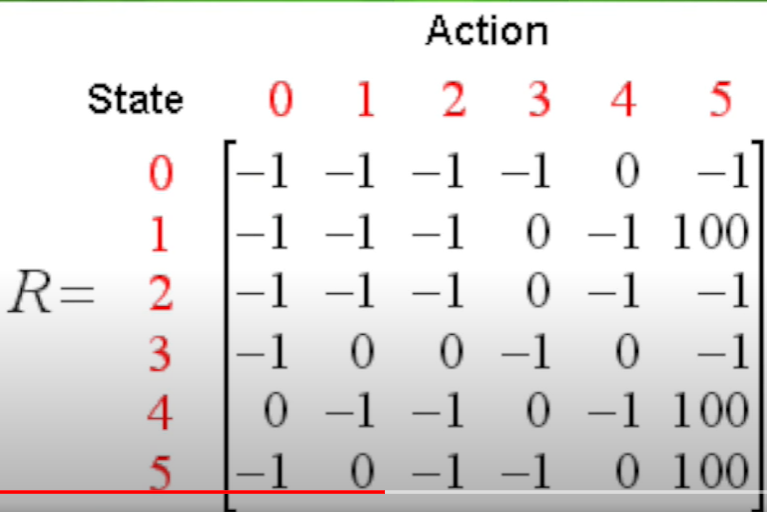

In [8]:
# #the actions are represented by the possible positions in the grid
actions = set(range(1, 9+1))
# q_table = np.zeros((num_states, num_actions))
# #put all of them equal to -1 to find the shortest solution ???
# for id,_ in enumerate(q_table): q_table[id] = -1

# q_table[1,2] = 10


def get_next_action(state,available, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon,
  #then choose the most promising value from the Q-table for this state.   - EXPLOITATION
  if np.random.random() < epsilon:
      #if the best one is not available, choose the next best available one
        q_values = q_table[state]
        #sort the actions according to their corresponding Q values
        sorted_actions = [x for _, x in sorted(zip(q_values, actions), reverse=True)]
        for action in sorted_actions:
            if action in available:
                return action

  else: #choose a random action     - EXPLORATION
    next_action = choice(list(available))
    return next_action

def extract_action(old_state, state):
    x_action = state.x - old_state.x
    o_action = state.o - old_state.o
    if x_action:
        return ('x', x_action.pop())
    elif o_action:
        return ('o', o_action.pop())
    else:
        return None

In [9]:
def random_game():
    trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))
    while available:
        x = choice(list(available))
        state.x.add(x)
        trajectory.append(deepcopy(state))
        available.remove(x)
        if win(state.x) or not available:
            print("x vince")
            break

        o = choice(list(available))
        state.o.add(o)
        trajectory.append(deepcopy(state))
        available.remove(o)
        if win(state.o):
            break
    return trajectory

In [78]:

reward = -1

# Q-LEARNING !!!!

def play_game(eps,discount_factor,lr):
    trajectory = list()
    actions_hist = list()
    state = State(set(), set())
    available = set(range(1, 9+1))
    tot_reward = 0
    turno = 0
    while available:
        turno +=1

        ####### now let your agent play its turn

        #calculate the CURRENT state index for the direct access to the q_table
        #print(f"old state: {state}")
        old_state_index = gray_code(state)
        #print(f"old state index: {old_state_index}")
        #print(old_state_index)

        #take the best action according to the current state
        action = get_next_action(old_state_index,available,eps)
        #print(f"action: {action}")

        #new state
        state.o.add(action)
        #print(f"new state: {state}")

        #reward after the action
        reward = state_value(state)
        #print(f"reward: {reward}")

        #calculate the NEW state index for the direct access to the q_table
        new_state_index = gray_code(state)
        #print(f"new_state_index: {new_state_index}")

        #print(new_state_index)
        #compute the REWARD according to the NEW state

        #tot_reward += reward

        #update the q_table using the Bellman function
        #print(f"q value before updating: {q_table[old_state_index][action-1]}")
        #q_table[old_state_index][action-1] =  (q_table[old_state_index][action-1] + lr*(reward + discount_factor *  np.max(q_table[new_state_index]) - q_table[old_state_index][action-1]))
        q_table[old_state_index][action-1] =  (1-lr)*np.max(q_table[new_state_index]) + lr*(reward + discount_factor *  np.max(q_table[new_state_index]))
        #print(f"q value after updating: {q_table[old_state_index][action-1]}")
        #print("   \n")
        trajectory.append(deepcopy(state))
        actions_hist.append(action)
        available.remove(action)

        if win(state.o):
            #print("o vince")
            trajectory.append(deepcopy(state))
            break
        #print(f"\nTurno {turno}")

        if not available:
          #print("pareggio")
          trajectory.append(deepcopy(state))
          break

####### x plays a random game ########

        x = choice(list(available))
        state.x.add(x)
        #trajectory.append(deepcopy(state))
        available.remove(x)


        if win(state.x):
            #if the opponent wins, then update the q-table of our agent penalizing the last state-action pair
            q_table[old_state_index][action-1] -= 100
            break





    return trajectory



# FIND THE BEST CONFIG FOR YOUR FINAL TRAINING


In [84]:
#define training parameters
 #the percentage of time when we should take the best action (instead of a random action)
dfs = [0.00001,0.0001,0.001,0.01,0.1] #discount factor for future rewards
lrs= [0.00001,0.0001,0.001,0.01,0.1] #the rate at which the AI agent should learn
epss = [0.1,0.3,0.5,0.7,0.9]
history = list()
"Best e: 0.9, best_df: 0.0001, best_lr: 0.1"

best_acc = None
best_e = None
best_df = None
best_lr = None

max_iter = 10_000


for df in dfs:
 for lr in lrs:
  for eps in epss:

    q_table = np.zeros((num_states, num_actions))
    # #put all of them equal to -1 to find the shortest solution ???
    # for id,_ in enumerate(q_table): q_table[id] = -1

    o_wins = 0
    iter= 0

    for _ in tqdm(range(max_iter)):
      trajectory = play_game(eps,df,lr)
      final_reward = state_value(trajectory[-1])
      if final_reward == 100:
        o_wins+=1
        history.append((iter,1))
      else:
        history.append((iter,0))
      iter+=1

    #let them play - 1000 iter for each config to test the systems
    o_wins = 0
    for _ in tqdm(range(1000)):
      trajectory = play_game(eps,df,lr)
      final_reward = state_value(trajectory[-1])
      #print(trajectory)
      if final_reward == 100:
        o_wins+=1


    acc = o_wins/1000
    print(f"Accuracy: {acc}, eps: {eps}, df: {df}, lr: {lr} ")

    if best_acc == None or acc > best_acc:
      best_acc = acc
      best_e = eps
      best_df = df
      best_lr = lr

print(f"Best e: {best_e}, best_df: {best_df}, best_lr: {best_lr}")
# history = np.array(history)
# plt.figure(figsize=(14, 4))
# plt.plot(history[:, 0], history[:, 1], marker=".")


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.611, eps: 0.1, df: 1e-05, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.64, eps: 0.3, df: 1e-05, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.648, eps: 0.5, df: 1e-05, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.695, eps: 0.7, df: 1e-05, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.699, eps: 0.9, df: 1e-05, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.597, eps: 0.1, df: 1e-05, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.663, eps: 0.3, df: 1e-05, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.664, eps: 0.5, df: 1e-05, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.69, eps: 0.7, df: 1e-05, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.685, eps: 0.9, df: 1e-05, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.627, eps: 0.1, df: 1e-05, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.607, eps: 0.3, df: 1e-05, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.656, eps: 0.5, df: 1e-05, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.673, eps: 0.7, df: 1e-05, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.695, eps: 0.9, df: 1e-05, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.596, eps: 0.1, df: 1e-05, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.629, eps: 0.3, df: 1e-05, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.684, eps: 0.5, df: 1e-05, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.674, eps: 0.7, df: 1e-05, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.677, eps: 0.9, df: 1e-05, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.609, eps: 0.1, df: 1e-05, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.623, eps: 0.3, df: 1e-05, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.659, eps: 0.5, df: 1e-05, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.661, eps: 0.7, df: 1e-05, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.696, eps: 0.9, df: 1e-05, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.599, eps: 0.1, df: 0.0001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.627, eps: 0.3, df: 0.0001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.659, eps: 0.5, df: 0.0001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.671, eps: 0.7, df: 0.0001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.686, eps: 0.9, df: 0.0001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.614, eps: 0.1, df: 0.0001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.655, eps: 0.3, df: 0.0001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.671, eps: 0.5, df: 0.0001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.685, eps: 0.7, df: 0.0001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.662, eps: 0.9, df: 0.0001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.63, eps: 0.1, df: 0.0001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.618, eps: 0.3, df: 0.0001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.659, eps: 0.5, df: 0.0001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.695, eps: 0.7, df: 0.0001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.665, eps: 0.9, df: 0.0001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.597, eps: 0.1, df: 0.0001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.612, eps: 0.3, df: 0.0001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.634, eps: 0.5, df: 0.0001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.668, eps: 0.7, df: 0.0001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.692, eps: 0.9, df: 0.0001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.61, eps: 0.1, df: 0.0001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.635, eps: 0.3, df: 0.0001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.654, eps: 0.5, df: 0.0001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.66, eps: 0.7, df: 0.0001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.68, eps: 0.9, df: 0.0001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.601, eps: 0.1, df: 0.001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.623, eps: 0.3, df: 0.001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.671, eps: 0.5, df: 0.001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.673, eps: 0.7, df: 0.001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.681, eps: 0.9, df: 0.001, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.595, eps: 0.1, df: 0.001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.617, eps: 0.3, df: 0.001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.679, eps: 0.5, df: 0.001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.687, eps: 0.7, df: 0.001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.707, eps: 0.9, df: 0.001, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.566, eps: 0.1, df: 0.001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.652, eps: 0.3, df: 0.001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.676, eps: 0.5, df: 0.001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.66, eps: 0.7, df: 0.001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.675, eps: 0.9, df: 0.001, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.608, eps: 0.1, df: 0.001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.636, eps: 0.3, df: 0.001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.637, eps: 0.5, df: 0.001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.686, eps: 0.7, df: 0.001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.689, eps: 0.9, df: 0.001, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.599, eps: 0.1, df: 0.001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.655, eps: 0.3, df: 0.001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.658, eps: 0.5, df: 0.001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.663, eps: 0.7, df: 0.001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.669, eps: 0.9, df: 0.001, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.589, eps: 0.1, df: 0.01, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.669, eps: 0.3, df: 0.01, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.64, eps: 0.5, df: 0.01, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.682, eps: 0.7, df: 0.01, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.693, eps: 0.9, df: 0.01, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.602, eps: 0.1, df: 0.01, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.607, eps: 0.3, df: 0.01, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.647, eps: 0.5, df: 0.01, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.675, eps: 0.7, df: 0.01, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.706, eps: 0.9, df: 0.01, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.608, eps: 0.1, df: 0.01, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.661, eps: 0.3, df: 0.01, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.664, eps: 0.5, df: 0.01, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.683, eps: 0.7, df: 0.01, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.707, eps: 0.9, df: 0.01, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.627, eps: 0.1, df: 0.01, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.652, eps: 0.3, df: 0.01, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.622, eps: 0.5, df: 0.01, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.683, eps: 0.7, df: 0.01, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.666, eps: 0.9, df: 0.01, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.602, eps: 0.1, df: 0.01, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.639, eps: 0.3, df: 0.01, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.643, eps: 0.5, df: 0.01, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.678, eps: 0.7, df: 0.01, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.689, eps: 0.9, df: 0.01, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.589, eps: 0.1, df: 0.1, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.654, eps: 0.3, df: 0.1, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.675, eps: 0.5, df: 0.1, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.672, eps: 0.7, df: 0.1, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.679, eps: 0.9, df: 0.1, lr: 1e-05 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.6, eps: 0.1, df: 0.1, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.632, eps: 0.3, df: 0.1, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.647, eps: 0.5, df: 0.1, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.665, eps: 0.7, df: 0.1, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.675, eps: 0.9, df: 0.1, lr: 0.0001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.61, eps: 0.1, df: 0.1, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.621, eps: 0.3, df: 0.1, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.645, eps: 0.5, df: 0.1, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.702, eps: 0.7, df: 0.1, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.692, eps: 0.9, df: 0.1, lr: 0.001 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.576, eps: 0.1, df: 0.1, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.622, eps: 0.3, df: 0.1, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.672, eps: 0.5, df: 0.1, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.654, eps: 0.7, df: 0.1, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.687, eps: 0.9, df: 0.1, lr: 0.01 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.61, eps: 0.1, df: 0.1, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.628, eps: 0.3, df: 0.1, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.679, eps: 0.5, df: 0.1, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.664, eps: 0.7, df: 0.1, lr: 0.1 


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.681, eps: 0.9, df: 0.1, lr: 0.1 
Best e: 0.9, best_df: 0.001, best_lr: 0.0001


# TRAIN WITH THE BEST CONFIGURATION


In [106]:
''' Best e: 0.9, best_df: 0.001, best_lr: 0.0001 in theory but pratically best_lr = 0.1 or 0.01'''
df = 0.001
lr = 0.1
eps = 0.9
max_iter = 200_000


q_table = np.zeros((num_states, num_actions))
  # #put all of them equal to -1 to find the shortest solution ???
  # for id,_ in enumerate(q_table): q_table[id] = -1

o_wins = 0
iter= 0

for _ in tqdm(range(max_iter)):
  trajectory = play_game(eps,df,lr)
  final_reward = state_value(trajectory[-1])
  if final_reward == 100:
    o_wins+=1

acc = o_wins/max_iter
print(f"Accuracy: {acc}, eps: {eps}, df: {df}, lr: {lr} ")


  0%|          | 0/200000 [00:00<?, ?it/s]

Accuracy: 0.706655, eps: 0.9, df: 0.001, lr: 0.1 


# TEST THE MODEL

In [115]:
o_wins = 0
max_iter = 1000
for _ in tqdm(range(max_iter)):
  trajectory = play_game(eps,df,lr)
  final_reward = state_value(trajectory[-1])
  #print(trajectory)
  if final_reward == 100:
    o_wins+=1

acc = o_wins/max_iter
print(acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.734


In [118]:
for x in np.ravel(q_table):
   if x > 1:
     print(x)

q_table

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5]])